In [1]:
import os
import time
import glob
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import Birch
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
path = "training_data/2020_04_11/"
df = pd.read_csv(path+'esb.csv')
df['date'] = pd.to_datetime(df.startTime, unit='ms')

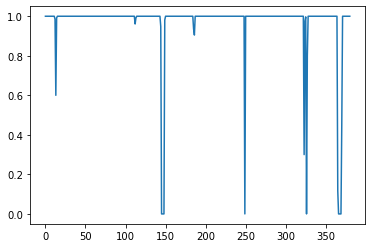

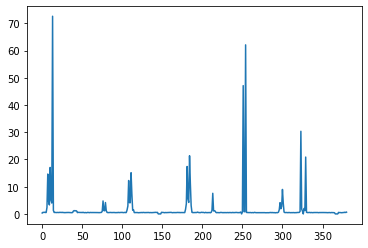

In [69]:
plt.plot(df['succee_rate'])
plt.show()
plt.plot(df['avg_time'])
plt.show()

## ESB data

In [28]:
from sklearn.cluster import Birch

def find_outliers(values):
    X = np.reshape(values, (-1, 1))
    brc = Birch(n_clusters=None)
    brc.fit(X)

    return brc.predict(X)

In [51]:
outlier= find_outliers(df['avg_time'].tolist())
outlier

In [62]:
df_temp = df[df.startTime < df.startTime[0]+300000]

In [63]:
outlier= find_outliers(df_temp['avg_time'].tolist())
outlier

array([0, 0, 0, 0, 0, 0])

In [113]:
df_temp = df[df.startTime <= df.startTime[0]+300000]

In [114]:
outlier= find_outliers(df_temp['avg_time'].tolist())
outlier

array([0, 0, 0, 0, 0, 0, 1, 2])

In [124]:
esb_anomalies = {}

In [125]:
start = 0
foundStart = False
current_start = 0
for i in range(len(outlier)):
    if (outlier[i]):
        if (i in esb_anomalies.keys()):
            start = i
            foundStart = True
        elif (foundStart and i == len(outlier)-1):
            esb_anomalies[start] = i
            foundStart = False
        else:
            if not (foundStart):
                esb_anomalies[i] = ''
                current_start = i
                break
    else:
        if (foundStart):
            esb_anomalies[start] = i-1
            foundStart = False
esb_anomalies

{6: ''}

## Trace data

In [179]:
path = 'training_data/2020_04_11/trace/'
csv_files = glob.glob(path+"*.csv")

df_trace = []
for file in csv_files:
    content = pd.read_csv(file)
    content = content[(content['startTime'] <= df_temp['startTime'][current_start]) & (content['startTime'] >= df_temp['startTime'][current_start]- 60000)]
    
    df_trace.append(content)

df_trace = pd.concat(df_trace, axis=0, ignore_index=True)
df_trace = df_trace.sort_values(by=['startTime'])

In [143]:
df_trace.drop('Unnamed: 0.1', axis=1, inplace=True)

In [180]:
df_trace['date'] = pd.to_datetime(df_trace.startTime, unit='ms')

In [181]:
len(df_trace)

22337

In [182]:
from datetime import datetime
def data_processing(data):
    data['serviceName'] = data['serviceName'].mask(pd.isnull, data['dsName'])

    # data['callType'] = pd.Categorical(data['callType'], ["OSB", "CSF", "LOCAL", "FlyRemote", "RemoteProcess", "JDBC"])
    # data = data.sort_values(["traceId","startTime"], ignore_index=True)
    data = data.sort_values(["startTime"], ignore_index=True)
    data = data[data.startTime < data.startTime[0]+100000]
    print(len(data))
    print('got subset')

    start_time = datetime.now()

    # Get the child's id and elapse time
    elapse_time = {}
    children = {}
    parent_service = {}
    for index, row in data.iterrows():
        if row['pid'] != 'None':
            if row['pid'] in children.keys():
                children[row['pid']].append(row['id'])
            else:
                children[row['pid']] = [row['id']]
        elapse_time[row['id']] = float(row['elapsedTime'])
        # If dont need parent node's info in path column just comment this
        parent_service[row['id']] = row['cmdb_id'] + \
            ':' + row['serviceName']

    # Compute for actual elapse_time and edge
    data['actual_time'] = 0.0
    data['path'] = ''
    for index, row in data.iterrows():
        total_child = 0.0

        # If dont need parent node's info in path column just comment this part
        if row['pid'] not in parent_service.keys():
            data.at[index, 'path'] = 'Start-' + \
                row['cmdb_id'] + ':' + row['serviceName']
        else:
            data.at[index, 'path'] = parent_service[row['pid']] + \
                '-' + row['cmdb_id'] + ':' + row['serviceName']

        if row['id'] not in children.keys():
            data.at[index, 'actual_time'] = row['elapsedTime']
            continue
        for child in children[row['id']]:
            total_child += elapse_time[child]
        data.at[index, 'actual_time'] = row['elapsedTime'] - total_child

    data['host_service'] = data.path.str.split('-').str[1]
    data['parent_host_service'] = data.path.str.split('-').str[0]
    data['parent'] = data.parent_host_service.str.split(':').str[1]

    strs = []
    structure_dict = {}
    data['trace_class'] = -1
    for name, group in data.groupby(['traceId']):
        structure = list(group.path.unique())
        structure.sort()
        if not (structure in strs):
            strs.append(structure)
            structure_dict[strs.index(structure)] = structure
        data.loc[data.traceId == name, ['trace_class']] = strs.index(structure)

    print(len(strs))

    total = datetime.now() - start_time
    print(total.total_seconds())

    return (data, structure_dict)

In [183]:
df_trace_structured, structure_dict = data_processing(df_trace)

22337
got subset
64
4.064906


In [288]:
df_trace_structured

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,dsName,date,actual_time,path,host_service,parent_host_service,parent,trace_class
0,OSB,1586534640027,233.0,True,7902717164d5699b6508,6bc9717164d5699b6509,None,os_021,osb_001,NaN,2020-04-10 16:04:00.027,38.0,Start-os_021:osb_001,os_021:osb_001,Start,NaN,0
1,OSB,1586534640027,588.0,True,105f917164d5699b6656,960e917164d5699b6657,None,os_021,osb_001,NaN,2020-04-10 16:04:00.027,158.0,Start-os_021:osb_001,os_021:osb_001,Start,NaN,20
2,OSB,1586534640028,547.0,True,f47dd17164d5699c6658,182b317164d5699c6659,None,os_021,osb_001,NaN,2020-04-10 16:04:00.028,127.0,Start-os_021:osb_001,os_021:osb_001,Start,NaN,48
3,OSB,1586534640028,586.0,True,6714717164d5699c6510,7338e17164d5699c6511,None,os_021,osb_001,NaN,2020-04-10 16:04:00.028,70.0,Start-os_021:osb_001,os_021:osb_001,Start,NaN,20
4,OSB,1586534640029,325.0,True,1d17a17164d5699d5628,d2e8217164d5699d5629,None,os_022,osb_001,NaN,2020-04-10 16:04:00.029,25.0,Start-os_022:osb_001,os_022:osb_001,Start,NaN,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22332,LOCAL,1586534662239,2.0,True,891e917164d5bca31966,ad94617164d5c05f1684,96c9b17164d5bcc61006,docker_003,local_method_009,db_009,2020-04-10 16:04:22.239,1.0,docker_003:csf_001-docker_003:local_method_009,docker_003:local_method_009,docker_003:csf_001,csf_001,20
22333,JDBC,1586534662240,1.0,True,891e917164d5bca31966,2415517164d5c0601690,ad94617164d5c05f1684,docker_003,db_009,db_009,2020-04-10 16:04:22.240,1.0,docker_003:local_method_009-docker_003:db_009,docker_003:db_009,docker_003:local_method_009,local_method_009,20
22334,JDBC,1586534662241,2.0,True,891e917164d5bca31966,4570317164d5c0611695,0d2b417164d5c0611692,docker_003,db_007,db_007,2020-04-10 16:04:22.241,2.0,docker_003:local_method_010-docker_003:db_007,docker_003:db_007,docker_003:local_method_010,local_method_010,20
22335,LOCAL,1586534662241,7.0,True,891e917164d5bca31966,0d2b417164d5c0611692,96c9b17164d5bcc61006,docker_003,local_method_010,db_007,2020-04-10 16:04:22.241,2.0,docker_003:csf_001-docker_003:local_method_010,docker_003:local_method_010,docker_003:csf_001,csf_001,20


In [282]:
def create_graph(trace_data):
    # creates weighted graph from the trace data
    base_graph =nx.DiGraph()
    edges = list(trace_data.path.unique())
    print('Creating graph of %d edges:' % len(edges))
    for edge in edges:
        source, destination = edge.split('-')
        if source != 'Start':
            data_subset = trace_data.loc[trace_data.path == edge]
            vector_of_actual_time = np.reshape(list(data_subset['actual_time']), (-1, 1))
            if len(vector_of_actual_time) > 10000:
                k = len(vector_of_actual_time) // 10000 + 1
                rnge = np.arange(len(vector_of_actual_time))
                indices = (rnge % k) == 0
                vector_of_actual_time = vector_of_actual_time[indices]                
            KDE = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(vector_of_actual_time)
            KDE_score = KDE.score_samples(vector_of_actual_time)
            outliers = np.where(vector_of_actual_time < np.percentile(vector_of_actual_time, 1))[0]
            if (len(outliers)):
                base_graph.add_edge(source, destination, weight=np.mean(KDE_score))
                print('Added edge: %s, ' % edge + 'KDE performed on %d rows' % len(vector_of_actual_time))
    print('Finished creating graph.')
    return base_graph

In [283]:
dgs = create_graph(df_trace_structured)

Creating graph of 180 edges:
Added edge: os_021:csf_001-docker_004:csf_001, KDE performed on 98 rows
Added edge: docker_004:csf_001-docker_004:fly_remote_001, KDE performed on 98 rows
Added edge: os_022:csf_001-docker_001:csf_001, KDE performed on 107 rows
Added edge: docker_003:csf_001-docker_003:csf_002, KDE performed on 94 rows
Added edge: docker_003:csf_002-docker_005:csf_002, KDE performed on 49 rows
Added edge: docker_001:csf_002-docker_007:csf_002, KDE performed on 48 rows
Added edge: docker_001:csf_002-docker_008:csf_002, KDE performed on 59 rows
Added edge: docker_004:csf_001-docker_004:csf_003, KDE performed on 98 rows
Added edge: docker_007:csf_002-docker_007:local_method_011, KDE performed on 91 rows
Added edge: docker_007:local_method_011-docker_007:db_003, KDE performed on 182 rows
Added edge: docker_008:local_method_014-docker_008:db_003, KDE performed on 106 rows
Added edge: docker_001:csf_003-docker_008:csf_003, KDE performed on 59 rows
Added edge: docker_003:csf_003-d

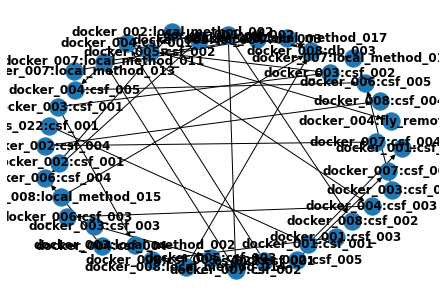

In [284]:
nx.draw(dgs, with_labels=True, font_weight="bold")

In [285]:
def page_rank():
    # use pagerank to locate the problematic service
    page_rank = nx.pagerank(dgs, alpha=0.85, max_iter=10000)
    page_rank = [(svc, val) for svc, val in dict(sorted(page_rank.items(), key=lambda item: item[1], reverse=True)).items()]
    print('All nodes listed by pagerank:')
    for svc, val in page_rank:
        print('Service name: ' + svc + ', pagerank score: %f' % val)
    return page_rank[0][0]

In [286]:
dodgy_nodes = page_rank()

All nodes listed by pagerank:
Service name: os_021:csf_001, pagerank score: 0.025000
Service name: docker_004:csf_001, pagerank score: 0.025000
Service name: docker_004:fly_remote_001, pagerank score: 0.025000
Service name: os_022:csf_001, pagerank score: 0.025000
Service name: docker_001:csf_001, pagerank score: 0.025000
Service name: docker_003:csf_001, pagerank score: 0.025000
Service name: docker_003:csf_002, pagerank score: 0.025000
Service name: docker_005:csf_002, pagerank score: 0.025000
Service name: docker_001:csf_002, pagerank score: 0.025000
Service name: docker_007:csf_002, pagerank score: 0.025000
Service name: docker_008:csf_002, pagerank score: 0.025000
Service name: docker_004:csf_003, pagerank score: 0.025000
Service name: docker_007:local_method_011, pagerank score: 0.025000
Service name: docker_007:db_003, pagerank score: 0.025000
Service name: docker_008:local_method_014, pagerank score: 0.025000
Service name: docker_008:db_003, pagerank score: 0.025000
Service nam

In [287]:
dodgy_nodes

'os_021:csf_001'

## Host data

In [197]:
path = 'training_data/2020_04_11/host/'
csv_files = glob.glob(path+"*.csv")
df_host = []
for file in csv_files:
    content = pd.read_csv(file)
    content = content[(content['timestamp'] <= df_temp['startTime'][current_start]) & (content['timestamp'] >= df_temp['startTime'][current_start]- 60000)]
        
    df_host.append(content)

df_host = pd.concat(df_host, axis=0, ignore_index=True)
df_host = df_host.sort_values(by=['timestamp'])

In [202]:
def find_outliers(values):
        X = np.reshape(values, (-1, 1))
        kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(X)
        yvals = kde.score_samples(X)
        outliers = np.where(yvals < np.percentile(yvals, 1))[0]

        return outliers

def find_root_causes(host_data, anom_hosts):
    print("Starting root cause detection...")

    host_groups = host_data[host_data['cmdb_id'].isin(
        anom_hosts)].groupby('cmdb_id')[['name', 'value']]

    root_causes = []
    for host, item in host_groups:
        df = host_groups.get_group(host)
        name_groups = df.groupby('name')['value'].apply(
            list).reset_index(name='values')
        print("Host %s has %d names" % (host, len(name_groups)))
        for i in range(len(name_groups)):
            row = name_groups.iloc[i]
            name = row['name']
            values = row['values']
            outliers = find_outliers(values)
            if (len(outliers)):
                root_causes.append([host, name])

    print("Root-cause detection finished with %d causes\n" %
            (len(root_causes)))
    return root_causes

In [203]:
root_causes = analyse_host_data(df_trace_structured, df_host, dodgy_nodes)

Possible route causes:


In [204]:
dodgy_nodes

'docker_005:db_003'